<a href="https://colab.research.google.com/github/SriVG17/Amazon_Sentiment_Analysis/blob/main/Amazon_Sentiment_analysis_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This is being used to identify and analyze customer reviews on Amazon products, helping to detect potentially artificial or biased reviews that may have been added by sellers to influence product ratings and increase sales.**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly import tools
from plotly.subplots import make_subplots
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer

init_notebook_mode(connected=True)
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data=pd.read_csv('/content/drive/MyDrive/amazon.csv')
print(data.shape)
data = data.head(500)
print(data.shape)


(4915, 12)
(500, 12)


In [5]:
data.head(20)

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,0,NaN,4,No issues.,23-07-2014,138,0,0,0,0,0.0,0.000000
1,1,0mie,5,"Purchased this for my device, it worked as adv...",25-10-2013,409,0,0,0,0,0.0,0.000000
2,2,1K3,4,it works as expected. I should have sprung for...,23-12-2012,715,0,0,0,0,0.0,0.000000
3,3,1m2,5,This think has worked out great.Had a diff. br...,21-11-2013,382,0,0,0,0,0.0,0.000000
4,4,2&amp;1/2Men,5,"Bought it with Retail Packaging, arrived legit...",13-07-2013,513,0,0,0,0,0.0,0.000000
5,5,2Cents!,5,It's mini storage. It doesn't do anything els...,29-04-2013,588,0,0,0,0,0.0,0.000000
6,6,2K1Toaster,5,I have it in my phone and it never skips a bea...,19-10-2013,415,0,0,0,0,0.0,0.000000
7,7,"35-year Technology Consumer ""8-tracks to 802.11""",5,It's hard to believe how affordable digital ha...,07-10-2014,62,0,0,0,0,0.0,0.000000
8,8,4evryoung,5,Works in a HTC Rezound. Was running short of ...,24-03-2014,259,1,0,1,1,1.0,0.206549
9,9,53rdcard,5,"in my galaxy s4, super fast card, and am total...",10-11-2013,393,0,0,0,0,0.0,0.000000


## `OVERALL REVIEWES`

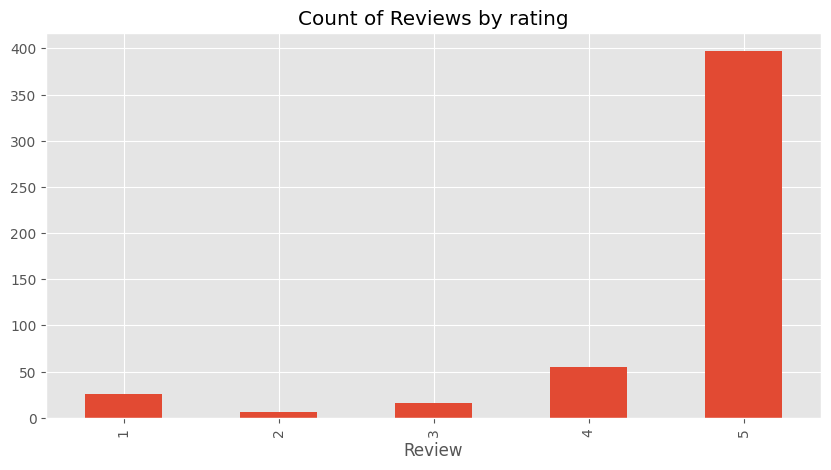

In [6]:
ax = data['overall'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by rating',
          figsize=(10, 5))
ax.set_xlabel('Review')
plt.show()

In [7]:

def missing_values_analysis(data):
    na_columns = [col for col in data.columns if data[col].isnull().sum() > 0]
    n_miss = data[na_columns].isnull().sum().sort_values(ascending=True)
    ratio = (data[na_columns].isnull().sum() / data.shape[0] * 100).sort_values(ascending=True)
    missing_data = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['Total Missing Values', 'Ratio'])
    missing_data = pd.DataFrame(missing_data)
    return missing_data

missing_values_analysis(data)


,Total Missing Values,Ratio
reviewerName,1,0.2
reviewText,1,0.2


In [8]:
def check_data(data, head=5, tail=5):
    print("SHAPE".center(82, '~'))
    print('Rows: {}'.format(data.shape[0]))
    print('Columns: {}'.format(data.shape[1]))

    print("TYPES".center(82, '~'))
    print(data.dtypes)

    print("MISSING VALUES".center(82, '~'))
    print(missing_values_analysis(data))

    print("DUPLICATED VALUES".center(82, '~'))
    print(data.duplicated().sum())

    print("QUANTILES".center(82, '~'))
    print(data.select_dtypes(include='number').quantile([0, 0.05, 0.95, 0.99, 1]).T)


check_data(data, head=5, tail=5)


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~SHAPE~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Rows: 500
Columns: 12
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~TYPES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Unnamed: 0                int64
reviewerName             object
overall                   int64
reviewText               object
reviewTime               object
day_diff                  int64
helpful_yes               int64
helpful_no                int64
total_vote                int64
score_pos_neg_diff        int64
score_average_rating    float64
wilson_lower_bound      float64
dtype: object
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~MISSING VALUES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
              Total Missing Values  Ratio
reviewerName                     1    0.2
reviewText                       1    0.2
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~DUPLICATED VALUES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~QUANTILES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                      0.00   0.05    

In [9]:
import pandas as pd

def check_class(data):
    nunique_data = pd.DataFrame({
        'Variable': data.columns,
        'classes': [data[col].nunique() for col in data.columns]
    })
    nunique_data = nunique_data.sort_values('classes', ascending=False)
    nunique_data = nunique_data.reset_index(drop=True)
    return nunique_data

check_class(data)


,Variable,classes
0,Unnamed: 0,500
1,reviewText,499
2,reviewerName,366
3,reviewTime,337
4,day_diff,337
5,wilson_lower_bound,15
6,score_pos_neg_diff,12
7,helpful_yes,10
8,total_vote,10
9,score_average_rating,10


## ***REVIEWES GIVEN BY THE USER ***

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

constraints = ['#B34D22', '#EBE00C', '#1FEB0C', '#0C92EB', '#EB0CB5']

def categorical_variable_summary(data, column_name):
    # Check if the column exists in the DataFrame
    if column_name not in data.columns:
        print(f"Error: Column '{column_name}' not found in the DataFrame.")
        return  # Exit the function if the column is not found

    # Count the values in the column
    value_counts = data[column_name].value_counts()

    # Create a figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Create bar chart on the first subplot
    sns.countplot(
        data=data,
        x=column_name,
        hue=column_name,          # Set `hue` to the same variable as `x`
        order=value_counts.index,
        palette=constraints,
        ax=axes[0],
        dodge=False                # Ensures that bars are not split by hue
    )
    axes[0].set_title(f'{column_name} - Count Plot')
    axes[0].set_xlabel(column_name)
    axes[0].set_ylabel('Count')
    axes[0].legend_.remove()       # Remove legend to avoid redundancy

    # Create pie chart on the second subplot
    axes[1].pie(
        value_counts,
        labels=value_counts.index,
        autopct='%1.1f%%',
        startangle=140,
        colors=constraints
    )
    axes[1].set_title(f'{column_name} - Percentage')

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()


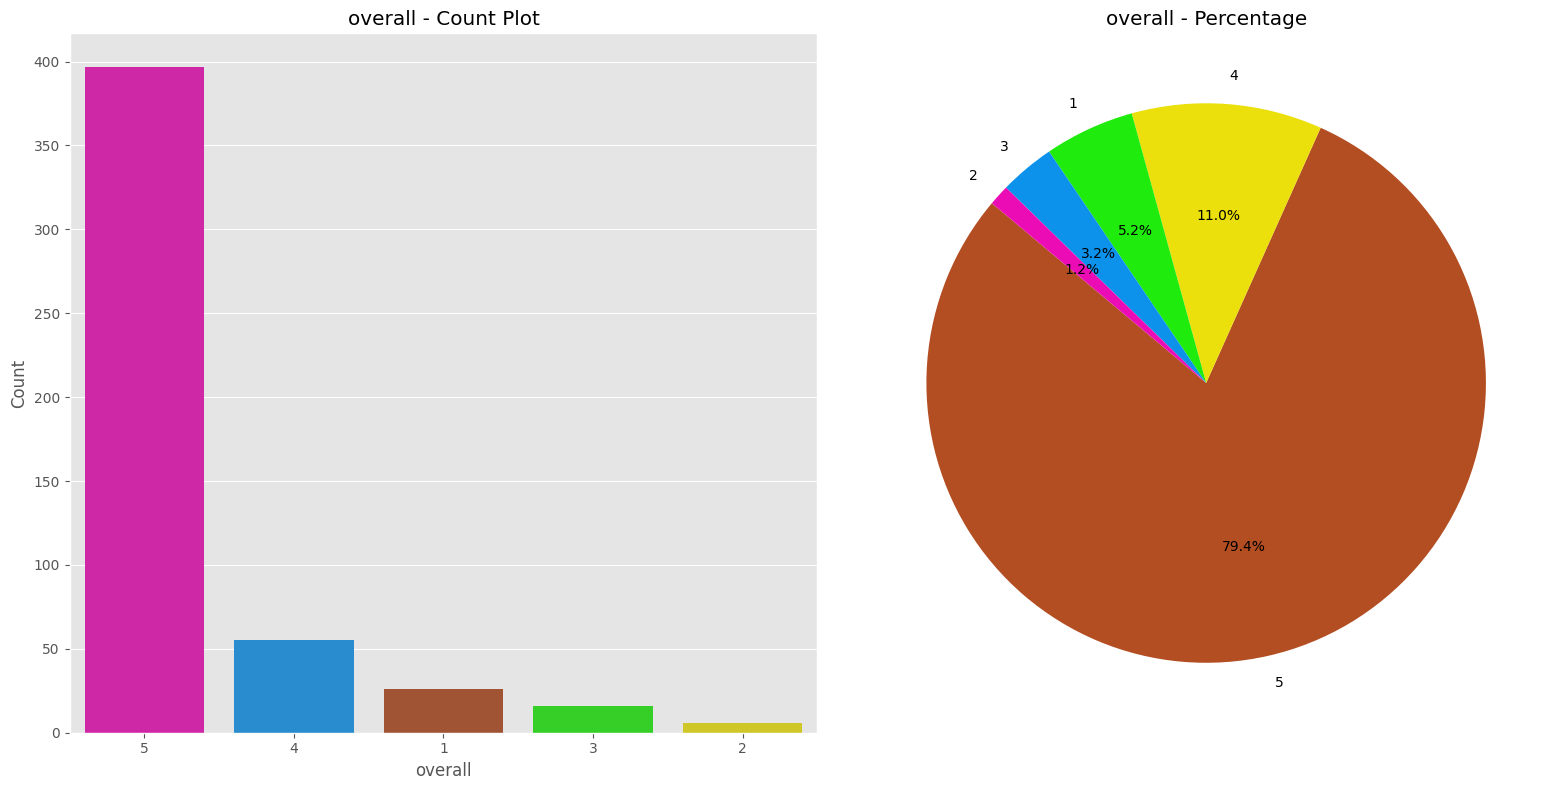

In [11]:
categorical_variable_summary(data,'overall')

In [12]:
example = data['reviewText'][50]
print(example)

A memory card either works or it doesn't. This was always going to be a one star or five star review - no middle ground.The adapter is a nice bonus too, though I don't think I have anything to use it with.


In [13]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['A', 'memory', 'card', 'either', 'works', 'or', 'it', 'does', "n't", '.']

In [14]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('A', 'DT'),
 ('memory', 'NN'),
 ('card', 'NN'),
 ('either', 'CC'),
 ('works', 'VBZ'),
 ('or', 'CC'),
 ('it', 'PRP'),
 ('does', 'VBZ'),
 ("n't", 'RB'),
 ('.', '.')]

In [15]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  A/DT
  memory/NN
  card/NN
  either/CC
  works/VBZ
  or/CC
  it/PRP
  does/VBZ
  n't/RB
  ./.
  This/DT
  was/VBD
  always/RB
  going/VBG
  to/TO
  be/VB
  a/DT
  one/CD
  star/NN
  or/CC
  five/CD
  star/NN
  review/NN
  -/:
  no/DT
  middle/JJ
  ground.The/NN
  adapter/NN
  is/VBZ
  a/DT
  nice/JJ
  bonus/NN
  too/RB
  ,/,
  though/IN
  I/PRP
  do/VBP
  n't/RB
  think/VB
  I/PRP
  have/VBP
  anything/NN
  to/TO
  use/VB
  it/PRP
  with/IN
  ./.)


In [16]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [17]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [18]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [ ]:
sia.polarity_scores(example)

{'neg': 0.053, 'neu': 0.795, 'pos': 0.152, 'compound': 0.6249}

In [19]:
res = {}
for i, row in tqdm(data.iterrows(), total=len(data)):
    text = row['reviewText']
    myid = row['reviewerName']
    # Check if text is a string before processing
    # If not a string (like nan), convert to string
    if not isinstance(text, str):
        text = str(text)
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [20]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'reviewerName'}) # Rename 'index' to 'reviewerName'
# Assuming 'data' has a column named 'reviewerName', merge on it
vaders = vaders.merge(data, on='reviewerName', how='left')

In [21]:
vaders.head()

,reviewerName,neg,neu,pos,compound,Unnamed: 0,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,NaN,0.688,0.312,0.000,-0.2960,0,4,No issues.,23-07-2014,138,0,0,0,0,0.0,0.0
1,0mie,0.075,0.925,0.000,-0.2960,1,5,"Purchased this for my device, it worked as adv...",25-10-2013,409,0,0,0,0,0.0,0.0
2,1K3,0.077,0.923,0.000,-0.3089,2,4,it works as expected. I should have sprung for...,23-12-2012,715,0,0,0,0,0.0,0.0
3,1m2,0.000,0.909,0.091,0.7081,3,5,This think has worked out great.Had a diff. br...,21-11-2013,382,0,0,0,0,0.0,0.0
4,2&amp;1/2Men,0.038,0.835,0.127,0.7087,4,5,"Bought it with Retail Packaging, arrived legit...",13-07-2013,513,0,0,0,0,0.0,0.0


In [22]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 8.7 MB/s eta 0:00:00


# **RESPONSE BASED ON COMPOUND SCORE**

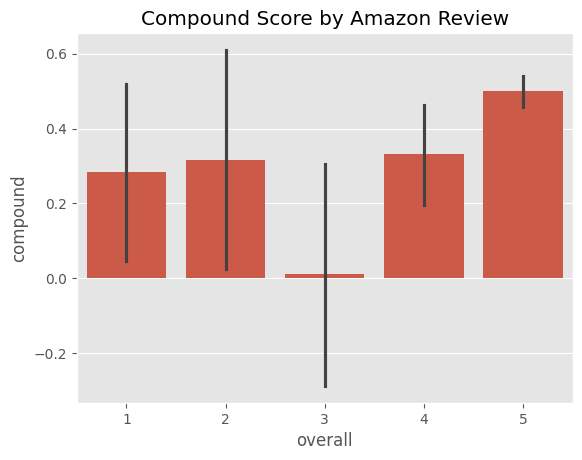

In [23]:
ax = sns.barplot(data=vaders, x='overall', y='compound')
ax.set_title('Compound Score by Amazon Review')
plt.show()

# **VARIETY OF REVIWES BASED ON OVERALL RATING**

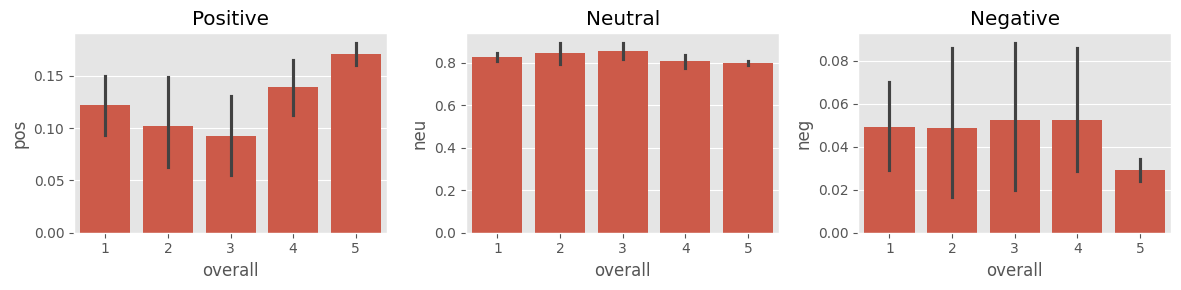

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='overall', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='overall', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='overall', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

In [25]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [26]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [27]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Create an instance of SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Call polarity_scores() on the instance
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [28]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [29]:
sia.polarity_scores(example)

{'neg': 0.053, 'neu': 0.795, 'pos': 0.152, 'compound': 0.6249}

In [30]:
!pip install tqdm # Install the tqdm module
from tqdm import tqdm # Import the tqdm function from the module
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

In [31]:
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.15133695, 'roberta_neu': 0.4059432, 'roberta_pos': 0.44271976}


In [32]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [33]:
res = {}
for i, row in tqdm(data.iterrows(), total=len(data)):
    try:
        text = row['reviewerName']
        # Check if 'text' is a string before processing
        if isinstance(text, str):
            myid = row['overall']
            vader_result = sia.polarity_scores(text)
            vader_result_rename = {}
            for key, value in vader_result.items():
                vader_result_rename[f"vader_{key}"] = value
            roberta_result = polarity_scores_roberta(text)
            both = {**vader_result_rename, **roberta_result}
            res[myid] = both
        else:
            print(f"Skipping row {i} due to invalid 'reviewerName': {text}") # Print a message for skipped rows
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

Skipping row 0 due to invalid 'reviewerName': nan


100%|██████████| 500/500 [01:21<00:00,  6.16it/s]


In [37]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'overall'}) # Rename 'index' to 'overall'
results_df = results_df.merge(data, on='overall', how='left') # Merge on 'overall'

In [38]:
results_df.columns

Index(['overall', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'Unnamed: 0',
       'reviewerName', 'reviewText', 'reviewTime', 'day_diff', 'helpful_yes',
       'helpful_no', 'total_vote', 'score_pos_neg_diff',
       'score_average_rating', 'wilson_lower_bound'],
      dtype='object')

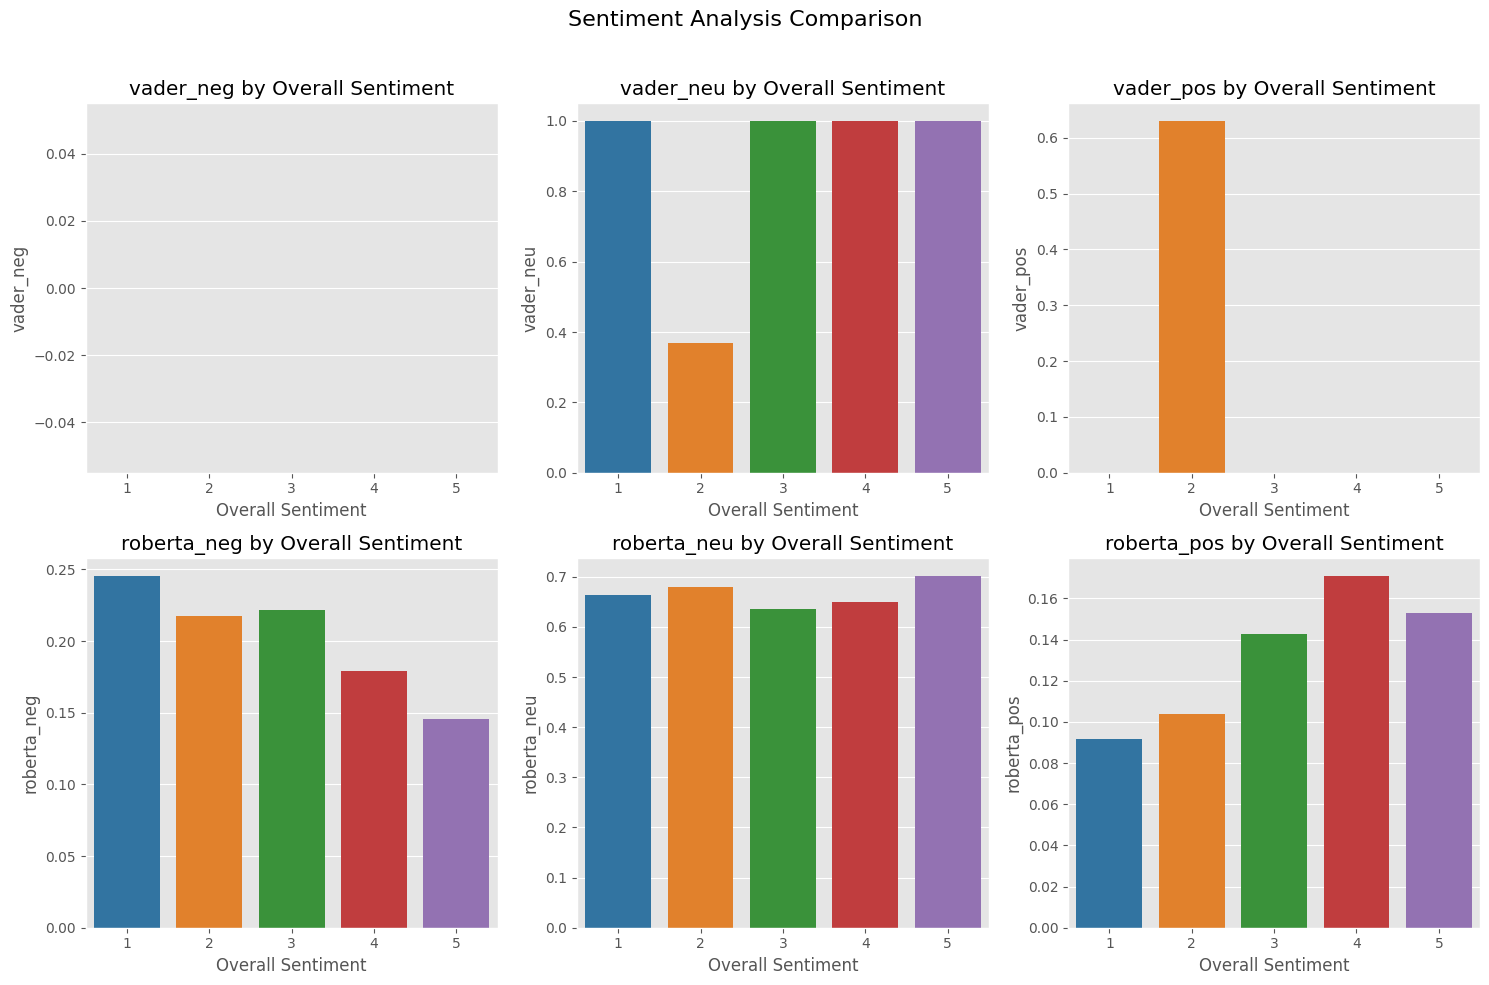

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the figure with subplots for each variable
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Sentiment Analysis Comparison', fontsize=16)

# Variables to plot
variables = ['vader_neg', 'vader_neu', 'vader_pos', 'roberta_neg', 'roberta_neu', 'roberta_pos']

# Iterate over variables and plot barplot for each
for var, ax in zip(variables, axes.flat):
    sns.barplot(data=results_df, x='overall', y=var, hue='overall', palette='tab10', ax=ax, dodge=False)
    ax.set_title(f'{var} by Overall Sentiment')
    ax.set_xlabel('Overall Sentiment')
    ax.set_ylabel(var)
    ax.legend_.remove()  # Remove legend in each subplot for clarity

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## **This suggests that the additional reviews, potentially generated using the VADER sentiment analysis tool, were artificially added by the seller to enhance the product’s appeal and increase sales.**